In [94]:
import numpy as np

from abtem import PixelatedDetector, SMatrix, GridScan, AnnularDetector, Potential, Probe
from ase.cluster import Decahedron

In [172]:
p = 4
q = 2
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
#atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=2)

In [237]:
potential = Potential(atoms=atoms, projection='infinite', parametrization='kirkland')
S = SMatrix(semiangle_cutoff = 10, energy=100e3, gpts=512, interpolation=2)

detector = PixelatedDetector(resample='uniform')

scan = GridScan((0,0), np.diag(atoms.cell)[:2], sampling=S.ctf.nyquist_sampling*.9)

measurement = S.scan(scan, detector, potential)

(60, 60, 113, 113)


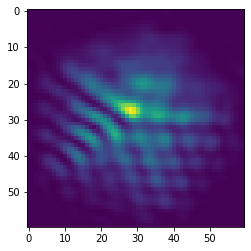

In [274]:
from abtem.utils import fft_interpolate_2d, fft_crop
import matplotlib.pyplot as plt

array = measurement.array

old_shape = array.shape

#array = array.reshape(array.shape[:2] + (-1,))

axes = (2,3)

array = np.moveaxis(array, axes, range(len(axes)))

rolled_shape = array.shape
    
array = array.reshape((-1,) + array.shape[-2:])
array = fft_interpolate_2d(array, (60,60))
array = array.reshape(rolled_shape[:len(axes)] + array.shape[-2:])
array = np.moveaxis(array, range(len(axes)), axes)


#print(array.shape, axis)

print(array.shape)

#array = np.rollaxis(array, axis=0, start=3)
#array = array.reshape(array.shape[:2] + old_shape[-2:])

plt.imshow(array[...,7,0])

#new_shape = (20,20,20,20)
#fft_crop(array, new_shape)

#new_array = fft_interpolate_2d(array, (20,20,20,20))

In [247]:
array.shape

(12769, 60, 60)

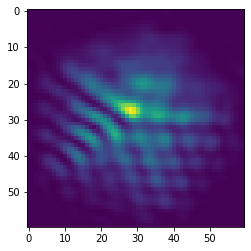

In [232]:
plt.imshow(array[:,:,7,0])

In [178]:
measurement = S.scan(scan, detector, potential)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x12b16a8cb20>)

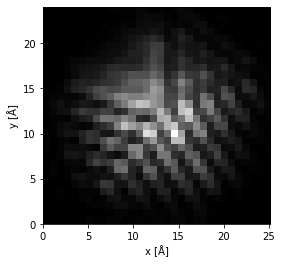

In [184]:
measurement[:,:,20,20].show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x12b171a6ac0>)

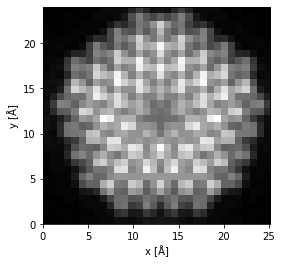

In [179]:
#AnnularDetector(30,80).integrate(measurement).interpolate.show()

In [2]:
import numpy as np

In [3]:
data = np.random.rand(10,10,10,10)

In [ ]:
throttling = 0.05

canvas1 = Canvas()
canvas2 = Canvas()

probe_artist = MeasurementArtist2d()
diffraction_artist = MeasurementArtist2d()